In [1]:
!python --version

Python 3.9.16


In [2]:
import numpy as np
np.version.version

'1.23.5'

In [5]:
import tensorflow as tf
assert tf.__version__.startswith('2')

In [6]:
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

In [7]:
!pip3 install chardet

In [8]:
## 3 classes with RGB converted... intact dataset
data = DataLoader.from_folder("/home/stark/thesis/sram/dataxmc/tflite/dataset/intact-rgb")

INFO:tensorflow:Load image with size: 303, num_label: 3, labels: board002A, board0035, board0088.


2023-07-31 15:54:33.110871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/stark/miniconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-31 15:54:33.110894: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-31 15:54:33.110911: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stark-labs): /proc/driver/nvidia/version does not exist
2023-07-31 15:54:33.111962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
train_data, test_data = data.split(0.8)

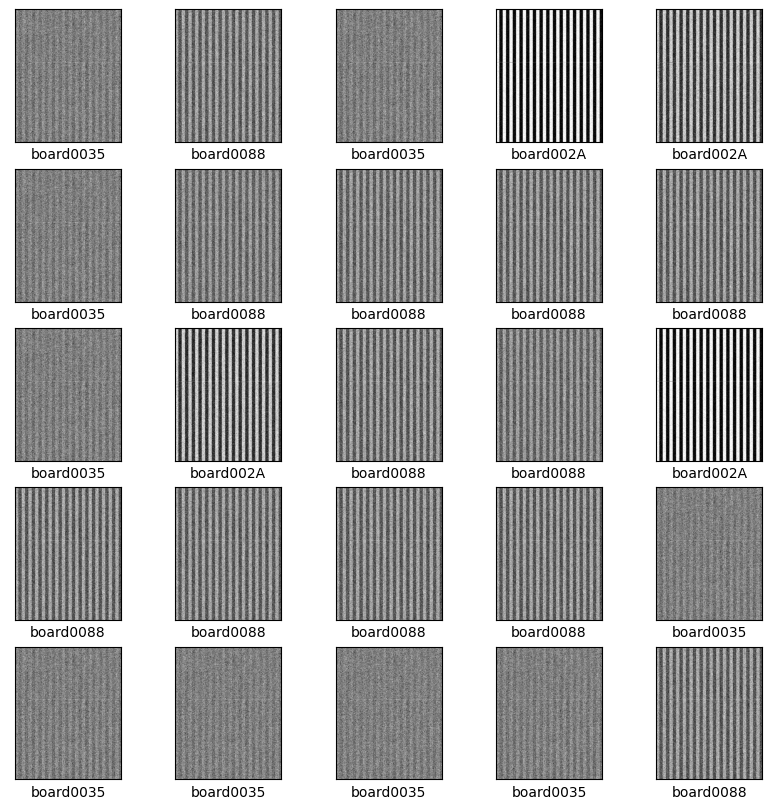

In [12]:
## show dataset with class labels
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()


In [13]:
## EfficientNet-Lite0 with default parameters
#model = image_classifier.create(train_data, validation_data=validation_data)

## EfficientNet-Lite0 with customized hyperparameters
model = image_classifier.create(train_data, 
                                model_spec=model_spec.get('efficientnet_lite0'), 
                                learning_rate=0.0005,
                                batch_size=32,
                                dropout_rate=0.65,
                                epochs=5)


INFO:tensorflow:Retraining the models...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
7/7 [==============================] - 10s 1s/step - loss: 1.5118 - accuracy: 0.2232 - val_loss: 1.0586 - val_accuracy: 0.3279
Epoch 2/5
7/7 [==============================] - 8s 1s/st

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 3,416,867
Trainable params: 3,843
Non-trainable params: 3,413,024
_________________________________________________________________


In [15]:
loss, accuracy = model.evaluate(test_data)

2/2 [==============================] - 3s 350ms/step - loss: 0.3386 - accuracy: 0.9508


In [16]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
epochs_range = range(5)

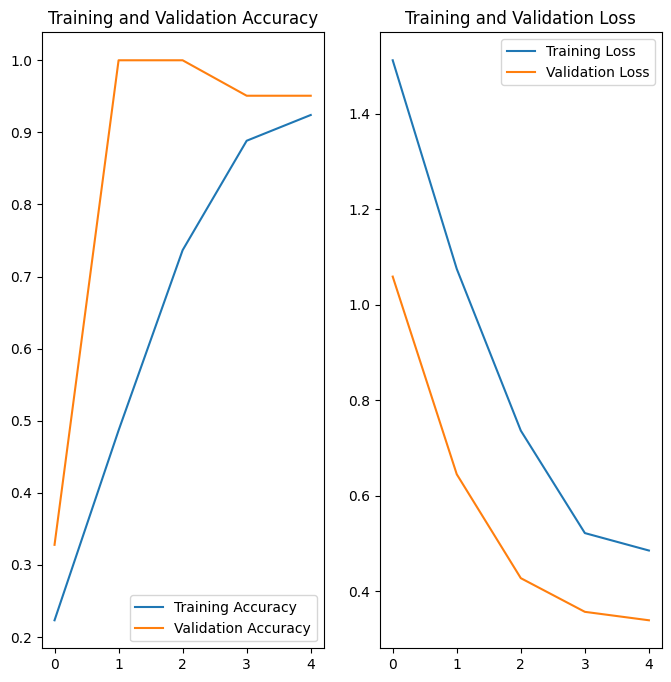

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.export(export_dir='/home/stark/thesis/sram/dataxmc/tflite/experiments/intact/efficientnet')

2023-07-31 16:10:31.542911: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpci4mhdvk/assets


INFO:tensorflow:Assets written to: /tmp/tmpci4mhdvk/assets
2023-07-31 16:10:36.256753: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-07-31 16:10:36.256909: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-07-31 16:10:36.304022: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1164] Optimization results for grappler item: graph_to_optimize
  function_optimizer: Graph size after: 913 nodes (656), 923 edges (664), time = 28.152ms.
  function_optimizer: function_optimizer did nothing. time = 0.014ms.

/home/stark/miniconda3/envs/py39/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-07-31 16:10:37.079603: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored 

INFO:tensorflow:Label file is inside the TFLite model with metadata.


fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp9smbm0ls/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp9smbm0ls/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: /home/stark/thesis/sram/dataxmc/tflite/experiments/intact/efficientnet/model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /home/stark/thesis/sram/dataxmc/tflite/experiments/intact/efficientnet/model.tflite


In [19]:
model.export(export_dir='/home/stark/thesis/sram/dataxmc/tflite/experiments/intact/efficientnet', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in /home/stark/thesis/sram/dataxmc/tflite/experiments/intact/efficientnet/labels.txt


INFO:tensorflow:Saving labels in /home/stark/thesis/sram/dataxmc/tflite/experiments/intact/efficientnet/labels.txt


In [20]:
model.evaluate_tflite('/home/stark/thesis/sram/dataxmc/tflite/experiments/intact/efficientnet/model.tflite', test_data)

{'accuracy': 0.9508196721311475}